# Automatic data labeling using Microsoft LLM : Florence-2

In [1]:
!pip install accelerate
!pip install flash_attn einops timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image , ImageDraw , ImageFont
from transformers import AutoProcessor , AutoModelForCausalLM

## importing Florence-2 model

In [3]:
model_id ="microsoft/Florence-2-large"
model = AutoModelForCausalLM.from_pretrained(model_id,trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id,trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
def florence2 (task_prompt,images,text_input):
  """
  Importing the Microsoft LLM Florence2 model
  """
  if text_input is None :
    prompt = task_prompt
  else :
    prompt = task_prompt + text_input
  inputs = processor(images=images,text=prompt,return_tensors="pt")
  generated_ids = model.generate(
      input_ids = inputs["input_ids"],
      pixel_values = inputs["pixel_values"],
      max_new_tokens=1024,
      do_sample=False,
      num_beams=3,
  )
  generated_text = processor.batch_decode(generated_ids,skip_special_tokens=False)[0]
  parsed_answer = processor.post_process_generation(
      generated_text,
      task=task_prompt,
      image_size=(image.width,image.height)
  )
  return parsed_answer


## Object Detection Task

In [5]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/car.jpg            
  inflating: data/cat.jpg            
  inflating: data/flower.jpg         
  inflating: data/people.jpg         
  inflating: data/tree.jpg           


In [5]:
image = Image.open('/content/data/car.jpg')
taskprompt='<OD>'
object_detection = florence2(taskprompt,image,None)
object_detection['<OD>']

{'bboxes': [[489.5999755859375,
   342.4794921875,
   1175.679931640625,
   740.8305053710938],
  [714.8800048828125, 583.0255126953125, 848.0, 737.41845703125],
  [510.0799865722656, 558.2885131835938, 592.0, 687.9444580078125],
  [1047.679931640625,
   630.7935180664062,
   1148.7999267578125,
   713.5344848632812]],
 'labels': ['car', 'wheel', 'wheel', 'wheel']}

In [6]:
def plot_bbox(image,data):
  fig,ax = plt.subplots()
  ax.imshow(image)
  for bbox , label in zip(data['bboxes'],data['labels']):
    x1,y1,x2,y2=bbox
    rectangle = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rectangle)
    plt.text(x1,y1,label,color='white',fontsize=8,bbox=dict(facecolor='red',alpha=0.5))
  ax.axis('off')
  plt.show()

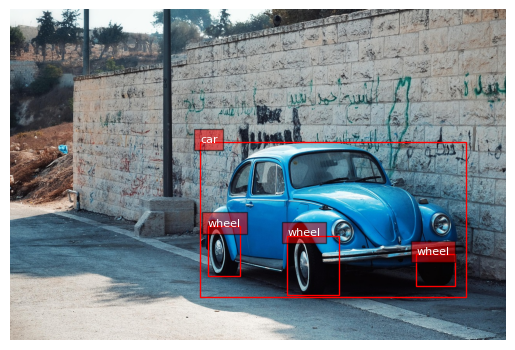

In [7]:
plot_bbox(image,object_detection['<OD>'])

## Guided Object Detection

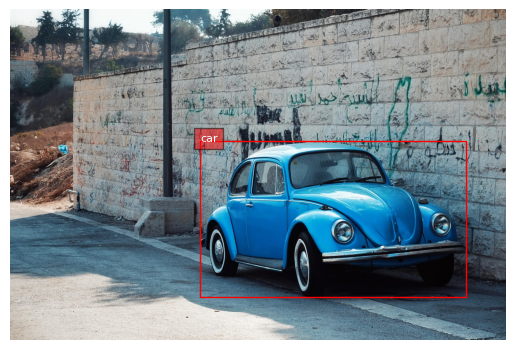

In [8]:
guided_prompt="<CAPTION_TO_PHRASE_GROUNDING>"
result = florence2(guided_prompt,image,"car")
plot_bbox(image,result['<CAPTION_TO_PHRASE_GROUNDING>']);

## Automatic Data Labeling

In [9]:
def florence2 (task_prompt,images,text_input):
  """
  Importing the Microsoft LLM Florence2 model
  """
  if text_input is None :
    prompt = task_prompt
  else :
    prompt = task_prompt + text_input
  inputs = processor(images=images,text=prompt,return_tensors="pt")
  generated_ids = model.generate(
      input_ids = inputs["input_ids"],
      pixel_values = inputs["pixel_values"],
      max_new_tokens=1024,
      do_sample=False,
      num_beams=3,
  )
  generated_text = processor.batch_decode(generated_ids,skip_special_tokens=False)[0]
  parsed_answer = processor.post_process_generation(
      generated_text,
      task=task_prompt,
      image_size=(image.width,image.height)
  )
  return parsed_answer


In [18]:
from PIL import Image
import os
def process_images(folder_path):
  image_files= [os.path.join(folder_path,f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

  for image_path in image_files :
    image_name = os.path.basename(image_path)
    image_name_without_extention= os.path.splitext(image_name)[0]
    try :
      image = Image.open(image_path)
    except IOError :
      print(f"Failed to open the image : {image_path}")
      continue
    task_prompt = '<OD>'

    object_detection_results = florence2(task_prompt,[image],None)

    # Check if object_detection_results is a dictionary and contains the '<OD>' key
    if isinstance(object_detection_results, dict) and '<OD>' in object_detection_results:
        results = object_detection_results['<OD>']  # Access the dictionary associated with '<OD>'
        output_file_path = os.path.join(folder_path, f'{image_name_without_extention}.txt')
        with open(output_file_path, 'w') as f:
            for key, value in results.items():
                f.write(f'{key} : {value}\n')
        print(f'Results for {image_name} saved to {output_file_path}')
    else:
        print(f"Unexpected result format for {image_name}: {object_detection_results}")

In [19]:
folder_path='/content/data'
process_images(folder_path)


Results for tree.jpg saved to /content/data/tree.txt
Results for flower.jpg saved to /content/data/flower.txt
Results for cat.jpg saved to /content/data/cat.txt
Results for car.jpg saved to /content/data/car.txt
Results for people.jpg saved to /content/data/people.txt


# Convert to YOLO Format

In [20]:
import os
import json

def convert_to_yolo_format(bboxes,labels,image_width,image_height):
  yolo_annotations = []

  for bbox , label in zip(bboxes,labels):
    xmin,ymin,xmax,ymax = bbox
    x_center = (xmin+xmax)/2/image_width
    y_center = (ymin+ymax)/2/image_height
    box_width = (xmax-xmin)/image_width
    box_height = (ymax-ymin)/image_height

    class_index = get_class_index(label)

    yolo_annotations.append(f"{class_index} {x_center} {y_center} {box_width} {box_height}")

  return yolo_annotations



In [21]:
def get_class_index(label):
  class_mapping = {
      'tree':0,
      'car':1,
      'person':2,
      'cat':3,
      'flower':4
  }

  return class_mapping.get(label,-1)


In [24]:
import os
from PIL import Image

def process_yolo_images(folder_path):
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]

    for image_path in image_files:
        image_name = os.path.basename(image_path)
        image_name_without_extension = os.path.splitext(image_name)[0]
        try:
            image = Image.open(image_path)
        except IOError:
            print(f"Failed to open the image: {image_path}")
            continue

        task_prompt = '<OD>'
        object_detection_results = florence2(task_prompt, [image], None)

        # Check if object_detection_results is a dictionary and contains the '<OD>' key
        if isinstance(object_detection_results, dict) and '<OD>' in object_detection_results:
            results = object_detection_results['<OD>']

            # Get image dimensions
            image_width, image_height = image.size

            # Convert to YOLO format
            yolo_annotations = convert_to_yolo_format(results['bboxes'], results['labels'], image_width, image_height)

            output_file_path = os.path.join(folder_path, f'{image_name_without_extension}_yolo.txt')
            with open(output_file_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))  # Write each annotation on a new line
            print(f'YOLO annotations for {image_name} saved to {output_file_path}')
        else:
            print(f"Unexpected result format for {image_name}: {object_detection_results}")

In [25]:
folder_path='/content/data'
process_yolo_images(folder_path)


YOLO annotations for tree.jpg saved to /content/data/tree_yolo.txt
YOLO annotations for flower.jpg saved to /content/data/flower_yolo.txt
YOLO annotations for cat.jpg saved to /content/data/cat_yolo.txt
YOLO annotations for car.jpg saved to /content/data/car_yolo.txt
YOLO annotations for people.jpg saved to /content/data/people_yolo.txt
